In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pybaseball as pyb
import matplotlib as mpl

In [215]:
# Define font properties for general text
font_properties = {'family': 'DejaVu Sans', 'size': 12}

# Define font properties for titles
font_properties_titles = {'family': 'DejaVu Sans', 'size': 20}

# Define font properties for axes labels
font_properties_axes = {'family': 'DejaVu Sans', 'size': 16}

# Set the theme for seaborn plots
sns.set_theme(style='whitegrid', 
              palette='deep', 
              font='DejaVu Sans', 
              font_scale=1.5, 
              color_codes=True, 
              rc=None)

# Import matplotlib


# Set the resolution of the figures to 300 DPI
mpl.rcParams['figure.dpi'] = 300

In [216]:
import pybaseball as pyb
print(pyb.playerid_lookup('Toglia','Michael'))

  name_last name_first  key_mlbam key_retro  key_bbref  key_fangraphs  \
0    toglia    michael     669911  toglm001  toglimi01          25845   

   mlb_played_first  mlb_played_last  
0            2022.0           2024.0  


In [217]:
print(pyb.playerid_lookup('Ohtani','Shohei'))
batter_id = 669911
df_pyb = pyb.statcast_batter('2024-03-28', '2024-10-01', batter_id)
sorted_columns = sorted(df_pyb.columns)
print(sorted_columns)
# df_pyb.head()

  name_last name_first  key_mlbam key_retro  key_bbref  key_fangraphs  \
0    ohtani     shohei     660271  ohtas001  ohtansh01          19755   

   mlb_played_first  mlb_played_last  
0            2018.0           2024.0  
Gathering Player Data
['age_bat', 'age_bat_legacy', 'age_pit', 'age_pit_legacy', 'api_break_x_arm', 'api_break_x_batter_in', 'api_break_z_with_gravity', 'arm_angle', 'at_bat_number', 'away_score', 'away_team', 'ax', 'ay', 'az', 'babip_value', 'balls', 'bat_score', 'bat_score_diff', 'bat_speed', 'bat_win_exp', 'batter', 'batter_days_since_prev_game', 'batter_days_until_next_game', 'bb_type', 'break_angle_deprecated', 'break_length_deprecated', 'delta_home_win_exp', 'delta_pitcher_run_exp', 'delta_run_exp', 'des', 'description', 'effective_speed', 'estimated_ba_using_speedangle', 'estimated_slg_using_speedangle', 'estimated_woba_using_speedangle', 'events', 'fielder_2', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 'fld_sc

In [218]:
def fangraphs_batting_leaderboards(season: int):
    url = f"https://www.fangraphs.com/api/leaders/major-league/data?age=&pos=all&stats=bat&lg=all&season={season}&season1={season}&ind=0&qual=0&type=0&month=0&pageitems=500000"
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data['data'])
    return df

# Example usage:
df_fangraphs = fangraphs_batting_leaderboards(season=2024)
print(df_fangraphs.head())

  Bats  xMLBAMID                                               Name  \
0    R    592450  <a href="statss.aspx?playerid=15640&position=O...   
1    R    677951  <a href="statss.aspx?playerid=25764&position=S...   
2    L    660271  <a href="statss.aspx?playerid=19755&position=D...   
3    L    665742  <a href="statss.aspx?playerid=20123&position=O...   
4    L    683002  <a href="statss.aspx?playerid=26289&position=3...   

                                                Team  Season   Age     AgeR  \
0  <a href="leaders.aspx?pos=all&stats=bat&lg=all...    2024  32.0  32 - 32   
1  <a href="leaders.aspx?pos=all&stats=bat&lg=all...    2024  24.0  24 - 24   
2  <a href="leaders.aspx?pos=all&stats=bat&lg=all...    2024  29.0  29 - 29   
3  <a href="leaders.aspx?pos=all&stats=bat&lg=all...    2024  25.0  25 - 25   
4  <a href="leaders.aspx?pos=all&stats=bat&lg=all...    2024  23.0  23 - 23   

   SeasonMin  SeasonMax      G  ...     TG    TPA   PlayerNameRoute  \
0       2024       2024  15

In [219]:
# pd.read_csv('BatterDataFG.csv')
# df_fangraphs = pd.read_csv('BatterDataFG.csv')
# print(df_fangraphs.head())

In [220]:
# Aggregate metrics for a hitter
total_pitches = len(df)
swing_rate = df['swing'].mean() * 100
contact_rate = df['contact'].mean() * 100
whiff_rate = df['whiff'].mean() * 100
chase_rate = df['chase'].mean() * 100
barrel_rate = df['barrel'].mean() * 100
hard_hit_rate = df['hard_hit'].mean() * 100

# Print hitter card stats
print(f"Total Pitches: {total_pitches}")
print(f"Swing Rate: {swing_rate:.2f}%")
print(f"Contact Rate: {contact_rate:.2f}%")
print(f"Whiff Rate: {whiff_rate:.2f}%")
print(f"Chase Rate: {chase_rate:.2f}%")
print(f"Barrel Rate: {barrel_rate:.2f}%")
print(f"Hard-Hit Rate: {hard_hit_rate:.2f}%")


Total Pitches: 2735
Swing Rate: 49.43%
Contact Rate: 41.90%
Whiff Rate: 7.50%
Chase Rate: 16.64%
Barrel Rate: 3.14%
Hard-Hit Rate: 12.07%


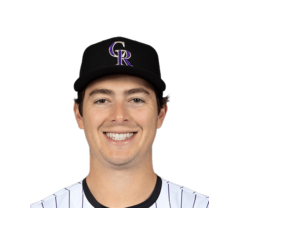

In [221]:
from PIL import Image
import requests
from io import BytesIO
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Function to get an image from a URL and display it on the given axis
def player_headshot(batter_id: str, ax: plt.Axes):
    # Construct the URL for the player's headshot image
    url = f'https://img.mlbstatic.com/mlb-photos/image/'\
          f'upload/d_people:generic:headshot:67:current.png'\
          f'/w_640,q_auto:best/v1/people/{batter_id}/headshot/silo/current.png'

    # Send a GET request to the URL
    response = requests.get(url)

    # Open the image from the response content
    img = Image.open(BytesIO(response.content))


    # Display the image on the axis
    ax.set_xlim(0, 1.3)
    ax.set_ylim(0, 1)
    ax.imshow(img, extent=[0, 1, 0, 1], origin='upper')

    # Turn off the axis
    ax.axis('off')


# Call the player_headshot function with the pitcher ID and current axis
player_headshot(batter_id=batter_id, ax=plt.subplots(figsize=(1, 1))[1])

In [229]:
# List of MLB teams and their corresponding ESPN logo URLs
mlb_teams = [
    {"team": "AZ", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/ari.png&h=500&w=500"},
    {"team": "ATL", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/atl.png&h=500&w=500"},
    {"team": "BAL", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/bal.png&h=500&w=500"},
    {"team": "BOS", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/bos.png&h=500&w=500"},
    {"team": "CHC", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/chc.png&h=500&w=500"},
    {"team": "CWS", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/chw.png&h=500&w=500"},
    {"team": "CIN", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/cin.png&h=500&w=500"},
    {"team": "CLE", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/cle.png&h=500&w=500"},
    {"team": "COL", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/col.png&h=500&w=500"},
    {"team": "DET", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/det.png&h=500&w=500"},
    {"team": "HOU", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/hou.png&h=500&w=500"},
    {"team": "KC", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/kc.png&h=500&w=500"},
    {"team": "LAA", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/laa.png&h=500&w=500"},
    {"team": "LAD", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/lad.png&h=500&w=500"},
    {"team": "MIA", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/mia.png&h=500&w=500"},
    {"team": "MIL", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/mil.png&h=500&w=500"},
    {"team": "MIN", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/min.png&h=500&w=500"},
    {"team": "NYM", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/nym.png&h=500&w=500"},
    {"team": "NYY", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/nyy.png&h=500&w=500"},
    {"team": "OAK", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/oak.png&h=500&w=500"},
    {"team": "PHI", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/phi.png&h=500&w=500"},
    {"team": "PIT", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/pit.png&h=500&w=500"},
    {"team": "SD", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/sd.png&h=500&w=500"},
    {"team": "SF", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/sf.png&h=500&w=500"},
    {"team": "SEA", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/sea.png&h=500&w=500"},
    {"team": "STL", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/stl.png&h=500&w=500"},
    {"team": "TB", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/tb.png&h=500&w=500"},
    {"team": "TEX", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/tex.png&h=500&w=500"},
    {"team": "TOR", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/tor.png&h=500&w=500"},
    {"team": "WSH", "logo_url": "https://a.espncdn.com/combiner/i?img=/i/teamlogos/mlb/500/scoreboard/wsh.png&h=500&w=500"}
]

# Create a DataFrame from the list of dictionaries
df_image = pd.DataFrame(mlb_teams)
image_dict = df_image.set_index('team')['logo_url'].to_dict()

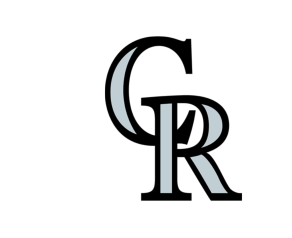

In [232]:
def plot_logo(batter_id: str, ax: plt.Axes):
    # Construct the URL to fetch player data
    url = f"https://statsapi.mlb.com/api/v1/people?personIds={batter_id}&hydrate=currentTeam"

    # Send a GET request to the URL and parse the JSON response
    data = requests.get(url).json()

    # Construct the URL to fetch team data
    url_team = 'https://statsapi.mlb.com/' + data['people'][0]['currentTeam']['link']

    # Send a GET request to the team URL and parse the JSON response
    data_team = requests.get(url_team).json()

    # Extract the team abbreviation
    team_abb = data_team['teams'][0]['abbreviation']

    # Get the logo URL from the image dictionary using the team abbreviation
    logo_url = image_dict[team_abb]

    # Send a GET request to the logo URL
    response = requests.get(logo_url)

    # Open the image from the response content
    img = Image.open(BytesIO(response.content))

    # Display the image on the axis
    ax.set_xlim(0, 1.3)
    ax.set_ylim(0, 1)
    ax.imshow(img, extent=[0.3, 1.3, 0, 1], origin='upper')

    # Turn off the axis
    ax.axis('off')

# Call the plot_logo function with the pitcher ID and a new axis of size 1x1
plot_logo(batter_id, ax=plt.subplots(figsize=(1, 1))[1])

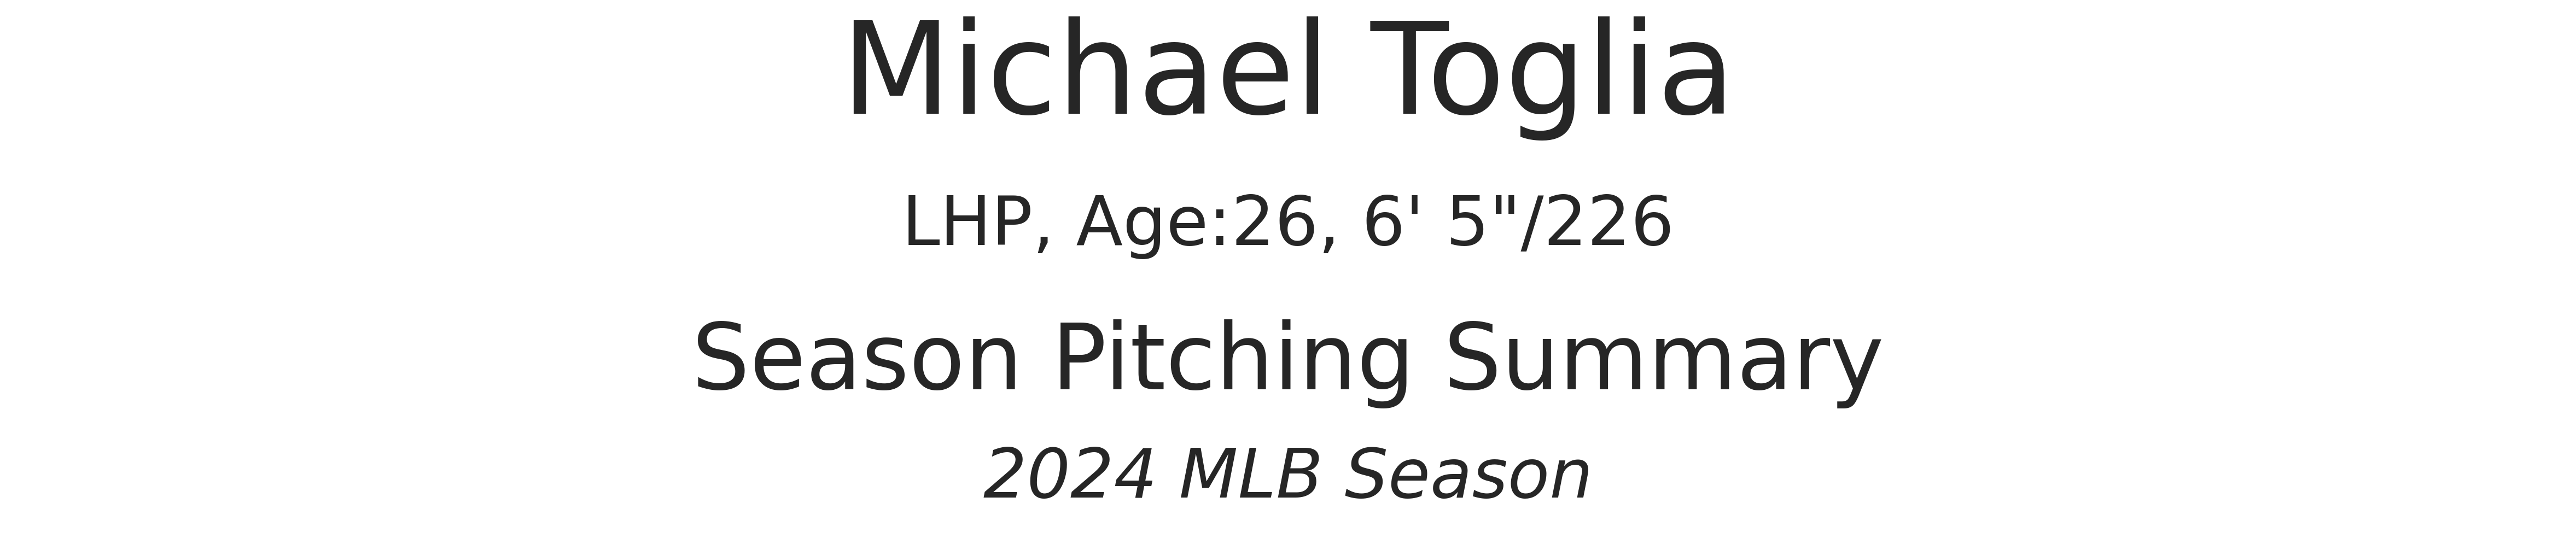

In [222]:
def player_bio(pitcher_id: str, ax: plt.Axes):
    # Construct the URL to fetch player data
    url = f"https://statsapi.mlb.com/api/v1/people?personIds={pitcher_id}&hydrate=currentTeam"

    # Send a GET request to the URL and parse the JSON response
    data = requests.get(url).json()

    # Extract player information from the JSON data
    player_name = data['people'][0]['fullName']
    pitcher_hand = data['people'][0]['pitchHand']['code']
    age = data['people'][0]['currentAge']
    height = data['people'][0]['height']
    weight = data['people'][0]['weight']

    # Display the player's name, handedness, age, height, and weight on the axis
    ax.text(0.5, 1, f'{player_name}', va='top', ha='center', fontsize=56)
    ax.text(0.5, 0.65, f'{pitcher_hand}HP, Age:{age}, {height}/{weight}', va='top', ha='center', fontsize=30)
    ax.text(0.5, 0.40, f'Season Pitching Summary', va='top', ha='center', fontsize=40)
    ax.text(0.5, 0.15, f'2024 MLB Season', va='top', ha='center', fontsize=30, fontstyle='italic')

    # Turn off the axis
    ax.axis('off')

# Call the player_bio function with the pitcher ID and a new axis of size 10x2
player_bio(batter_id, ax=plt.subplots(figsize=(20, 4))[1])

       G     PA       AVG       OBP      SLG       OPS       ISO       WAR
0  116.0  458.0  0.218045  0.310722  0.45614  0.766862  0.238095  0.417674


C:\Users\Jackson\AppData\Local\Temp\ipykernel_19684\2306637525.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '116' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_fangraphs_batter.loc[0] = [format(df_fangraphs_batter[x][0],fangraphs_stats_dict[x]['format']) for x in df_fangraphs_batter]
C:\Users\Jackson\AppData\Local\Temp\ipykernel_19684\2306637525.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '458' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_fangraphs_batter.loc[0] = [format(df_fangraphs_batter[x][0],fangraphs_stats_dict[x]['format']) for x in df_fangraphs_batter]
C:\Users\Jackson\AppData\Local\Temp\ipykernel_19684\2306637525.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an

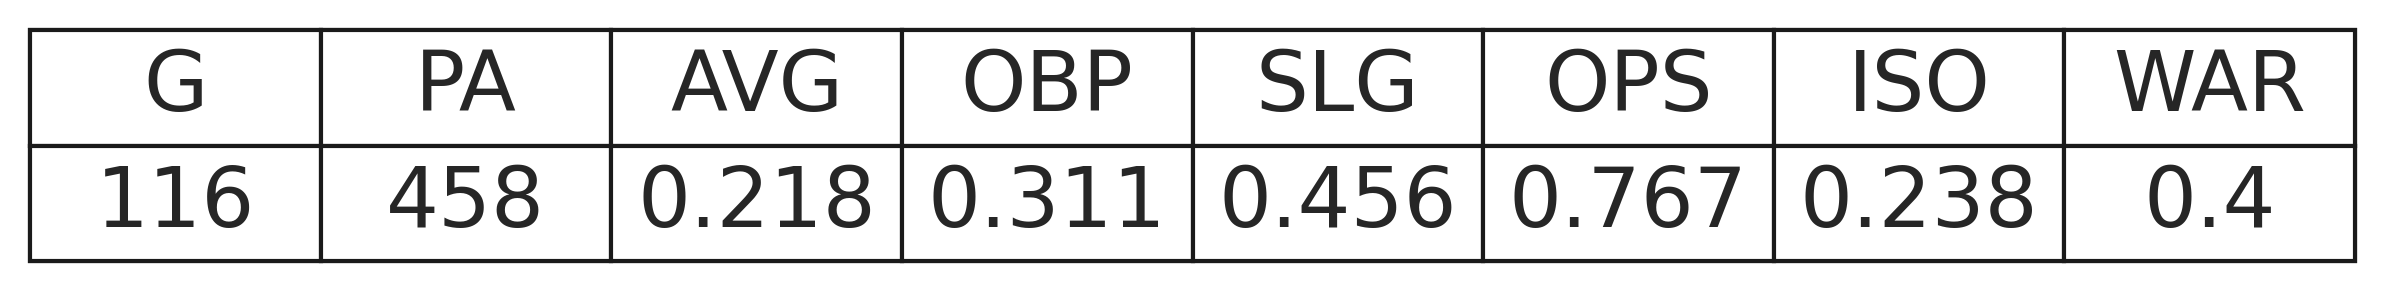

In [223]:
from matplotlib import font_manager

fangraphs_stats_dict = {
    'G': {'table_header': '$\\bf{G}$', 'format': '.0f'},         # Integer
    'PA': {'table_header': '$\\bf{PA}$', 'format': '.0f'},        # Integer
    'wOBA': {'table_header': '$\\bf{wOBA}$', 'format': '.3f'},     # Float (3 decimals)
    'wRC+': {'table_header': '$\\bf{wRC+}$', 'format': '.0f'},     # Integer (rounded)
    'AVG': {'table_header': '$\\bf{AVG}$', 'format': '.3f'},       # Float (3 decimals)
    'OBP': {'table_header': '$\\bf{OBP}$', 'format': '.3f'},       # Float (3 decimals)
    'SLG': {'table_header': '$\\bf{SLG}$', 'format': '.3f'},       # Float (3 decimals)
    'OPS': {'table_header': '$\\bf{OPS}$', 'format': '.3f'},       # Float (3 decimals)
    'WAR': {'table_header': '$\\bf{WAR}$', 'format': '.1f'},
    'ISO': {'table_header': '$\\bf{ISO}$', 'format': '.3f'},
}

def fangraphs_batter_stats(batter_id: int, ax: plt.Axes, stats: list, season: int, fontsize: int = 20):
    df_fangraphs = fangraphs_batting_leaderboards(season=season)

    df_fangraphs_batter = df_fangraphs[df_fangraphs['xMLBAMID'] == batter_id][stats].reset_index(drop=True)
    print(df_fangraphs_batter)
        
    df_fangraphs_batter.loc[0] = [format(df_fangraphs_batter[x][0],fangraphs_stats_dict[x]['format']) for x in df_fangraphs_batter]
    
    
    table_fg = ax.table(cellText=df_fangraphs_batter.values, colLabels=stats, cellLoc='center',
                    bbox=[0.00, 0.0, 1, 1])
    # Create the table
    table_fg = ax.table(cellText=df_fangraphs_batter.values, colLabels=stats, cellLoc='center', bbox=[0.00, 0.0, 1, 1])

    # Set font size for each cell's text
    for key, cell in table_fg.get_celld().items():
        if cell._text:
            cell._text.set_fontsize(fontsize)

    ax.axis('off')

stats = ['G','PA','AVG','OBP','SLG','OPS','ISO','WAR']
fangraphs_batter_stats(batter_id = batter_id,
                        ax = plt.subplots(figsize=(10, 1))[1],
                        stats = stats,
                        season = 2024)

In [224]:
print(batter_id)
stats = ['Name', 'Age', 'Team', 'G', 'PA', 'wOBA', 'wRC+','AVG','OBP','SLG','OPS']
batter_df = df_fangraphs[df_fangraphs['xMLBAMID'] == batter_id][stats].reset_index(drop=True)
print(batter_df)


669911
                                                Name   Age  \
0  <a href="statss.aspx?playerid=25845&position=1...  25.0   

                                                Team      G     PA     wOBA  \
0  <a href="leaders.aspx?pos=all&stats=bat&lg=all...  116.0  458.0  0.32924   

        wRC+       AVG       OBP      SLG       OPS  
0  98.162634  0.218045  0.310722  0.45614  0.766862  


In [225]:
# Retrieve the Fangraphs data for inspection
df_fangraphs = fangraphs_batting_leaderboards(season=2024)

# Check the first few rows and column data types
print(df_fangraphs.head())
print(df_fangraphs.dtypes)

  Bats  xMLBAMID                                               Name  \
0    R    592450  <a href="statss.aspx?playerid=15640&position=O...   
1    R    677951  <a href="statss.aspx?playerid=25764&position=S...   
2    L    660271  <a href="statss.aspx?playerid=19755&position=D...   
3    L    665742  <a href="statss.aspx?playerid=20123&position=O...   
4    L    683002  <a href="statss.aspx?playerid=26289&position=3...   

                                                Team  Season   Age     AgeR  \
0  <a href="leaders.aspx?pos=all&stats=bat&lg=all...    2024  32.0  32 - 32   
1  <a href="leaders.aspx?pos=all&stats=bat&lg=all...    2024  24.0  24 - 24   
2  <a href="leaders.aspx?pos=all&stats=bat&lg=all...    2024  29.0  29 - 29   
3  <a href="leaders.aspx?pos=all&stats=bat&lg=all...    2024  25.0  25 - 25   
4  <a href="leaders.aspx?pos=all&stats=bat&lg=all...    2024  23.0  23 - 23   

   SeasonMin  SeasonMax      G  ...     TG    TPA   PlayerNameRoute  \
0       2024       2024  15

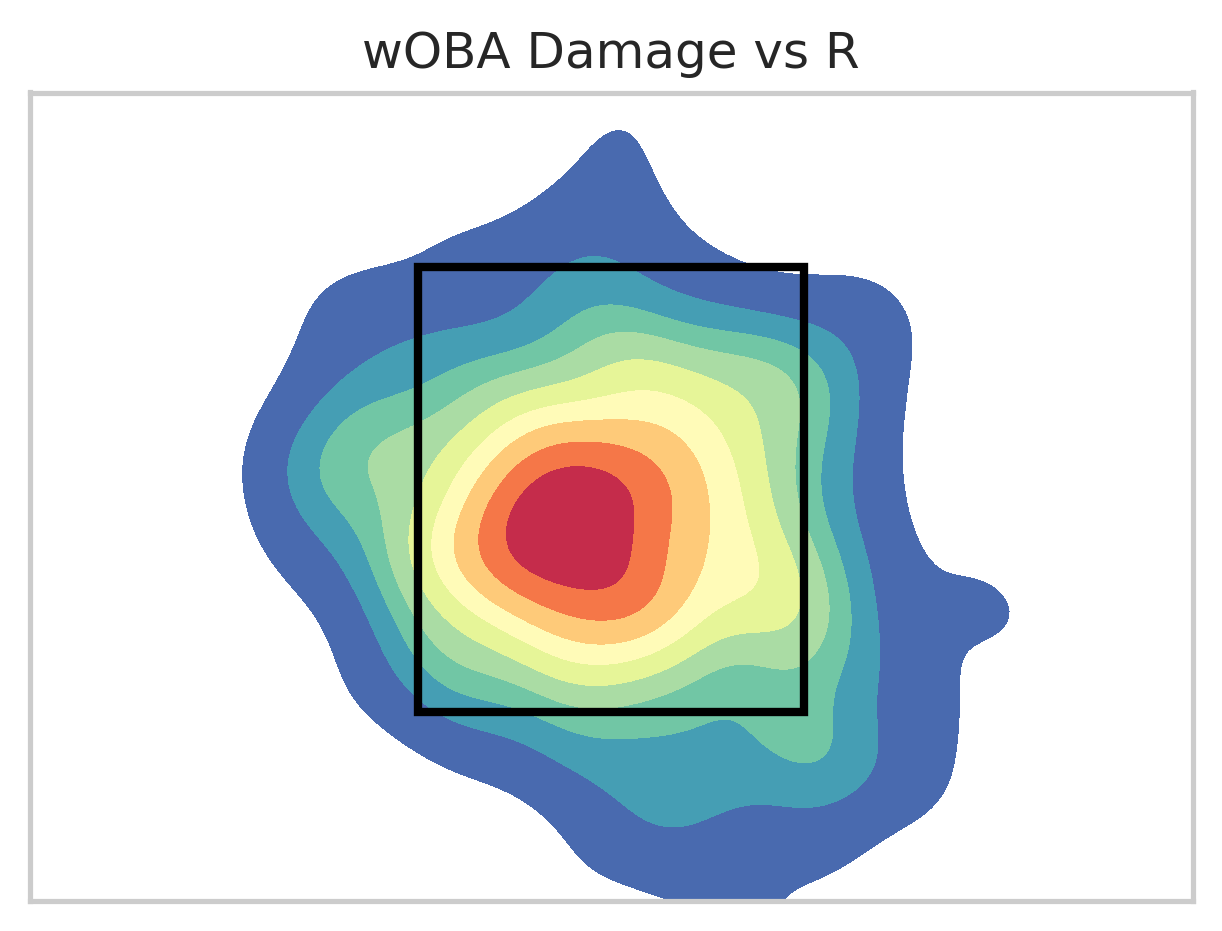

In [226]:
import matplotlib.patches as patches

filtered_df = df_pyb[(df_pyb['plate_x'].notnull()) & (df_pyb['plate_z'].notnull()) & (df_pyb['woba_value'].notnull()) & (df_pyb['p_throws'] == 'R')]


plate_damage_df = pd.DataFrame({
    'plate_x': filtered_df['plate_x'],
    'plate_z': filtered_df['plate_z'],
    'damage': filtered_df['woba_value']
})

# Define the corner coordinates for the rectangle
min_plate_x = -0.83
max_plate_x = 0.83
min_plate_z = 1.17
max_plate_z = 3.92

# Create the heatmap (you can use hexbin or kdeplot as shown earlier)
plt.figure(figsize=(5, 3.5))

# KDE plot with plate_x and plate_z as the axes, and damage as the color
sns.kdeplot(data=plate_damage_df, x='plate_x', y='plate_z', cmap='Spectral_r', fill=True, cbar=False, bw_adjust=.9)

# Create a rectangle using the given corner coordinates
rectangle = patches.Rectangle(
    (min_plate_x, min_plate_z),  # Lower left corner
    max_plate_x - min_plate_x,   # Width
    max_plate_z - min_plate_z,   # Height
    linewidth=2,                 # Line width
    edgecolor='black',             # Rectangle border color
    facecolor='none',            # No fill color inside the rectangle
    linestyle='-'               # Dotted line style
)

plt.gca().add_patch(rectangle)
plt.xlim(-2.5, 2.5)
plt.ylim(0,5)
plt.xticks([])  # Remove x-axis numbers
plt.yticks([])  # Remove y-axis numbers
plt.grid(False)
# Optionally, remove spines for a cleaner look
sns.set(style="white")

# Add labels and title
plt.title("wOBA Damage vs R")
plt.xlabel("")
plt.ylabel("")

# Show the plot
plt.show()

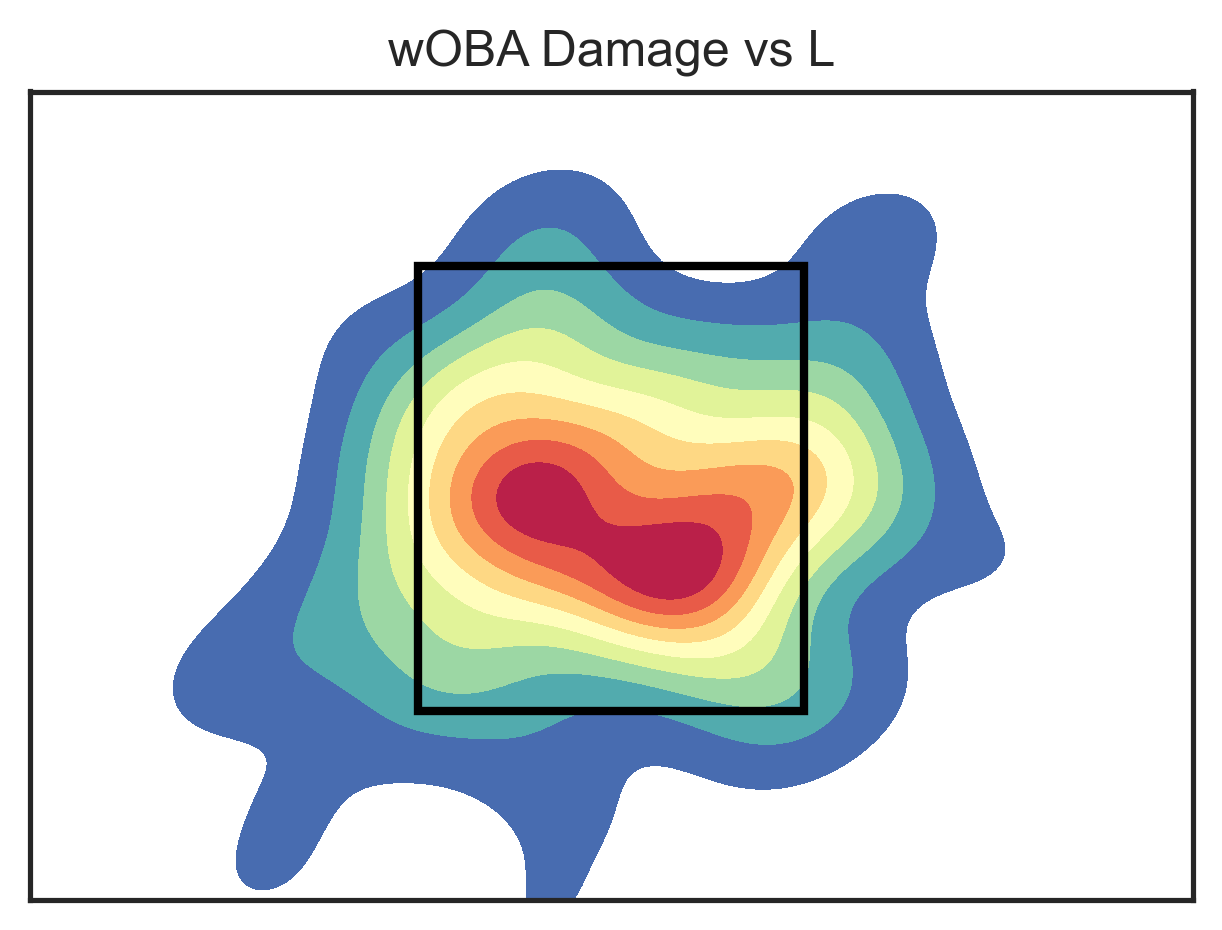

In [227]:

import matplotlib.patches as patches

filtered_df = df_pyb[(df_pyb['plate_x'].notnull()) & (df_pyb['plate_z'].notnull()) & (df_pyb['woba_value'].notnull()) & (df_pyb['p_throws'] == 'L')]


plate_damage_df = pd.DataFrame({
    'plate_x': filtered_df['plate_x'],
    'plate_z': filtered_df['plate_z'],
    'damage': filtered_df['woba_value']
})

# Define the corner coordinates for the rectangle
min_plate_x = -0.83
max_plate_x = 0.83
min_plate_z = 1.17
max_plate_z = 3.92

# Create the heatmap (you can use hexbin or kdeplot as shown earlier)
plt.figure(figsize=(5, 3.5))

# KDE plot with plate_x and plate_z as the axes, and damage as the color
sns.kdeplot(data=plate_damage_df, x='plate_x', y='plate_z', cmap='Spectral_r', fill=True, cbar=False, bw_adjust=.9)

# Create a rectangle using the given corner coordinates
rectangle = patches.Rectangle(
    (min_plate_x, min_plate_z),  # Lower left corner
    max_plate_x - min_plate_x,   # Width
    max_plate_z - min_plate_z,   # Height
    linewidth=2,                 # Line width
    edgecolor='black',             # Rectangle border color
    facecolor='none',            # No fill color inside the rectangle
    linestyle='-'               # Dotted line style
)

plt.gca().add_patch(rectangle)
plt.xlim(-2.5, 2.5)
plt.ylim(0,5)
plt.xticks([])  # Remove x-axis numbers
plt.yticks([])  # Remove y-axis numbers
plt.grid(False)
# Optionally, remove spines for a cleaner look
sns.set(style="white")

# Add labels and title
plt.title("wOBA Damage vs L")
plt.xlabel("")
plt.ylabel("")

# Show the plot
plt.show()
